In [1]:
import numpy as np
from random import random as rand
from math import floor
from numba import cuda

import matplotlib.pyplot as plt

# Optimization SN P Systems

In [2]:
threads_per_block = (32,32)
blocks_per_grid = (4,4)
H = 128
m = 128
runs = 250

In [3]:
# Defining 2 fitness functions:
# 1 is basic sum of components
# 2 is knapsack problem

def fitness(arr):
    return np.sum(arr)

omega = m*3
K = m
w = np.random.randint(1, omega, K)
p = w + 0.5*omega
C = 0.5*np.sum(w)

def fitness_knapsack(arr):
    knapsack = np.sum(np.multiply(arr, p))
    load = np.sum(np.multiply(arr, w))
    return knapsack if load <= C else -1

In [4]:
# prob matrix P => chromosome matrix T
# serial version

def spike(P):
    T = np.zeros((H, m))
    for i in range(H):
        for j in range(m):
            if (rand() < P[i,j]):
                T[i,j] = 1
                
    return T

In [6]:
# generate fitness vector of chromosomes
# return the most fit chromie

def fitness_vector(T):
    F = [fitness_knapsack(T[i]) for i in range(H)]
    return F

def fitness_argmax(F):
    arg = 0
    for i in range(1, H):
        arg = i if F[i] > F[arg] else arg
    return arg

In [7]:
# chromosome matrix T, prob matrix P, fitness vector F => new prob matrix P
# serial version

def guide(T, P, F, F_argmax):
    for i in range(H):
        for j in range(m):
            if (rand() < a[j]):
                k1, k2 = i, i
                while (k1 == i or k2 == i):
                    k1, k2 = [floor(rand() * H) for i in range(2)]
                b = T[k1,j] if F[k1] > F[k2] else T[k2,j]
                P[i,j] = P[i,j] + delta if b > 0.5 else P[i,j] - delta
            else:
                P[i,j] = P[i,j] + delta if T[F_argmax,j] > 0.5 else P[i,j] - delta
            
            # Adjustments
            if P[i,j] > 1:
                P[i,j] -= delta
            if P[i,j] < 0:
                P[i,j] += delta
    return P

## Parallel versions of spiking and guiding

In [5]:
# prob matrix P => chromosome matrix T
# serial version

@cuda.jit
def parallel_spike(P,Rand,T):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Set as squares
    block_size_x = cuda.blockDim.x
    block_size_y = cuda.blockDim.y
    grid_size_x = cuda.gridDim.x
    grid_size_y = cuda.gridDim.y

    # For matrices larger than the grid
    start_x = block_size_x * bx + tx
    start_y = block_size_y * by + ty
    stride_x = block_size_x * grid_size_x
    stride_y = block_size_y * grid_size_y
    
    for x in range(start_x, P.shape[0], stride_x):
        for y in range(start_y,P.shape[1],stride_y):
            T[x,y] = 1 if Rand[0,x,y] < P[x,y] else 0

In [8]:
@cuda.jit
def parallel_guide(T, P, F, F_argmax, a, delta, Rand, Randbit):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Set as squares
    block_size_x = cuda.blockDim.x
    block_size_y = cuda.blockDim.y
    grid_size_x = cuda.gridDim.x
    grid_size_y = cuda.gridDim.y

    # For matrices larger than the grid
    start_x = block_size_x * bx + tx
    start_y = block_size_y * by + ty
    stride_x = block_size_x * grid_size_x
    stride_y = block_size_y * grid_size_y
    
    # Redefine some things
    H, m = P.shape

    for x in range(start_x, H, stride_x):
        for y in range(start_y, m, stride_y):
            if(Rand[1,x,y] < a[y]):
                P[x,y] = P[x,y] + delta if Randbit[x,y] > 0.5 else P[x,y] - delta
            else:
                P[x,y] = P[x,y] + delta if T[F_argmax,y] > 0.5 else P[x,y] - delta
            if P[x,y] > 1:
                P[x,y] -= delta
            if P[x,y] < 0:
                P[x,y] += delta

In [9]:
@cuda.jit
def parallel_guide_striding(T, P, F, F_argmax, a, delta, Rand):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Set as squares
    block_size_x = cuda.blockDim.x
    block_size_y = cuda.blockDim.y
    grid_size_x = cuda.gridDim.x
    grid_size_y = cuda.gridDim.y

    # For matrices larger than the grid
    start_x = block_size_x * bx + tx
    start_y = block_size_y * by + ty
    stride_x = block_size_x * grid_size_x
    stride_y = block_size_y * grid_size_y
    
    # Redefine some things
    H, m = P.shape
    ctr = 0

    for x in range(start_x, H, stride_x):
        page_end = (ctr+1)*stride_x if (ctr+1)*stride_x < H else H
        page_start = ctr*stride_x
        page_size = page_end - page_start
        for y in range(start_y, m, stride_y):
            if(Rand[1,x,y] < a[y]):
                # MAKE SURE YOU'RE ONLY GETTING CHROMOSOMES FROM LOADED MEMORY
                k1 = (int)(Rand[2,x,y]*page_size + page_start)
                k2 = (int)(Rand[3,x,y]*page_size + page_start)
                if F[k1] > F[k2]:
                    b = T[k1,y]
                else:
                    b = T[k2,y]
                P[x,y] = P[x,y] + delta if b > 0.5 else P[x,y] - delta
            else:
                P[x,y] = P[x,y] + delta if T[F_argmax,y] > 0.5 else P[x,y] - delta

            if P[x,y] > 1:
                P[x,y] -= delta
            if P[x,y] < 0:
                P[x,y] += delta
        ctr += 1

## Serial

In [9]:
# Define the initial probability array and learning rate
P = np.random.random_sample((H, m))
a = 0.15 * np.random.random_sample(m) + 0.05
delta = 0.015 * rand() + 0.005

In [33]:
# game loop
# initial fitness

T = spike(P)
F = fitness_vector(T)

ave_fitness = []
ave_fitness.append(np.mean(F))

max_fitness = []
max_fitness.append(np.max(F))

In [34]:
for r in range(runs):
    guide(T, P, F, fitness_argmax(F))
    T = spike(P)
    F = fitness_vector(T)
    ave_fitness.append(np.mean(F))
    max_fitness.append(np.max(F))

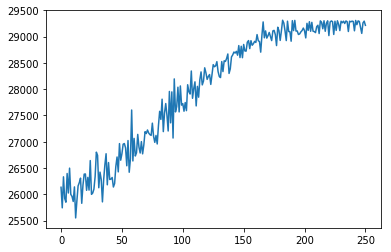

In [35]:
plt.plot(np.arange(runs+1), max_fitness)

## Parallel

In [33]:
# Define the initial probability array and learning rate
P = np.random.random_sample((H, m))
P_device = cuda.to_device(P)

a = 0.15 * np.random.random_sample(m) + 0.05
a_device = cuda.to_device(a)
delta = 0.015 * rand() + 0.005

In [34]:
# game loop
# initial fitness

T = np.zeros((H,m))
T_device = cuda.to_device(T)
Rand = np.random.random_sample((1, H, m))
Rand_device = cuda.to_device(Rand)

parallel_spike[blocks_per_grid, threads_per_block](P_device,Rand_device,T_device)
F = fitness_vector(T_device.copy_to_host())

ave_fitness = []
ave_fitness.append(np.mean(F))

max_fitness = []
max_fitness.append(np.max(F))

In [35]:
for r in range(runs):
    Rand = np.random.random_sample((2, H, m))
    Rand_tmp = np.random.randint(H, size=(2, H, m))
    
    # Preprocess the crossover
    Ttmp = T_device.copy_to_host()
    Rand_chromo = [
        [
            Rand_tmp[0,i,j] if F[Rand_tmp[0,i,j]] > F[Rand_tmp[1,i,j]] else Rand_tmp[1,i,j]
            for j in range(m)
        ]
        for i in range(H)
    ]

    Randbit = np.array([
        [
            Ttmp[Rand_chromo[i][j],j]
            for j in range(m)
        ]
        for i in range(H)
    ])
    
    Rand_device = cuda.to_device(Rand)
    Randbit_device = cuda.to_device(Randbit)

    F_argmax = fitness_argmax(F)
    F_device = cuda.to_device(F)
    parallel_guide[blocks_per_grid, threads_per_block](T_device,P_device,F_device,F_argmax,a_device,delta,Rand_device,Randbit_device)
    parallel_spike[blocks_per_grid, threads_per_block](P_device,Rand_device,T_device)

    F = fitness_vector(T_device.copy_to_host())
    ave_fitness.append(np.mean(F))
    max_fitness.append(np.max(F))

CudaAPIError: [701] Call to cuLaunchKernel results in CUDA_ERROR_LAUNCH_OUT_OF_RESOURCES

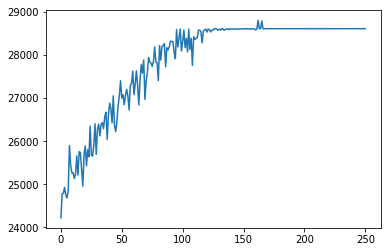

In [32]:
plt.plot(np.arange(runs+1), max_fitness)